In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from tqdm.notebook import tqdm
from ignite.metrics import Accuracy, Precision, Recall

In [2]:
train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

In [3]:
class MNISTDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, phase='train', normalize = None, augment = None):
        self.phase = phase
        if self.phase == 'train':
            start = 0
            end = int(0.9 * len(dataset.data))
        elif self.phase == 'val':
            start = int(0.9 * len(dataset.data))
            end = len(dataset.data)
        else:
            start = 0
            end = len(dataset.data)
        
        self.data = dataset.data[start:end]
        self.targets = dataset.targets[start:end]
        self.normalize = normalize
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = np.array(self.data[idx])
        cl = self.targets[idx]
        
        if self.augment:
            sample, cl = self.augment(image=sample, target=cl).values()
        
        if self.normalize:
            sample = self.normalize(sample)
        
        #sample = sample.flatten()
        
        return sample, cl

In [4]:
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.13, std=0.3)
])

transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=1.0),
    A.GaussNoise(p=1.0)
])

In [5]:
train_dataset = MNISTDataset(train, 'train', normalize=normalize, augment=transform)
val_dataset = MNISTDataset(train, 'val', normalize=normalize, augment=None)
test_dataset = MNISTDataset(test, 'test', normalize=normalize, augment=None)

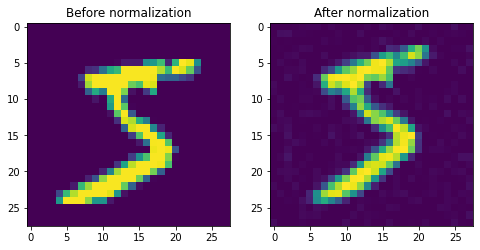

In [6]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 8)

axs[0].imshow(train[0][0].reshape(28, 28))
axs[0].set_title('Before normalization')

axs[1].imshow(train_dataset[0][0].reshape(28, 28))
axs[1].set_title('After normalization')

plt.show()

In [7]:
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(7*7*64, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10),
)

In [8]:
batch_size = 64
learning_rate = 0.01
num_epochs = 30

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

model.to(device)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=3136, out_features=1024, bias=True)
  (12): ReLU()
  (13): Linear(in_features=1024, out_features=512, bias=True)
  (14): ReLU()
  (15): Linear(in_features=512, out_features=10, bias=True)
)

In [12]:
total_progress = tqdm(total=num_epochs, desc='Total progress')
epoch_losses = []
epoch_accuracies = []
accuracy = Accuracy()

for epoch in range(num_epochs):
    model.train()
    epoch_progress = tqdm(total=len(train_loader), desc=f'Training epoch #{epoch}...', leave=False)
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        epoch_progress.update()
    epoch_progress.close()
    
    model.eval()
    val_progress = tqdm(total=len(val_loader), desc=f'Validating epoch #{epoch}...', leave=False)
    val_losses = []
    accuracy.reset()
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = loss_fn(output, target)
        val_losses.append(loss.item())
        val_progress.update()
        accuracy.update((output, target))
    val_progress.close()
    
    mean_val_loss = np.mean(val_losses)
    epoch_losses.append(mean_val_loss)
    current_accuracy = accuracy.compute()
    epoch_accuracies.append(current_accuracy)
    if current_accuracy == max(epoch_accuracies):
        torch.save(model, 'best_accuracy.pt')
        
    scheduler.step(mean_val_loss)
    
    print(f"Val loss #{epoch}: {np.mean(val_losses)}")
    print(f"Val accuracy #{epoch}: {current_accuracy}")
    
    total_progress.update()

total_progress.close()

Val loss #0: 0.5828943075017726
Val accuracy #0: 0.806


Val loss #1: 0.1332383720560911
Val accuracy #1: 0.9613333333333334


Val loss #2: 0.0780433021470944
Val accuracy #2: 0.9756666666666667


Val loss #3: 0.07035754600594296
Val accuracy #3: 0.9791666666666666


Val loss #4: 0.059273751993153365
Val accuracy #4: 0.9826666666666667


Val loss #5: 0.04690648832338604
Val accuracy #5: 0.986


Val loss #6: 0.0764055583663805
Val accuracy #6: 0.9771666666666666


Val loss #7: 0.038382665076766145
Val accuracy #7: 0.9893333333333333


Val loss #8: 0.036484976573426156
Val accuracy #8: 0.9905


Val loss #9: 0.0396766745399602
Val accuracy #9: 0.9885


Val loss #10: 0.03868565888594876
Val accuracy #10: 0.9885


Val loss #11: 0.03612529784623667
Val accuracy #11: 0.99


Val loss #12: 0.035493845578457695
Val accuracy #12: 0.9913333333333333


Val loss #13: 0.03690620399271559
Val accuracy #13: 0.9898333333333333


Val loss #14: 0.032186977087165246
Val accuracy #14: 0.9905


Val loss #15: 0.0344771166103957
Val accuracy #15: 0.991


Val loss #16: 0.03785512962829361
Val accuracy #16: 0.9903333333333333


Val loss #17: 0.03427436015710477
Val accuracy #17: 0.9903333333333333


Val loss #18: 0.03414376715730388
Val accuracy #18: 0.9923333333333333


Val loss #19: 0.029391037312962
Val accuracy #19: 0.9931666666666666


Val loss #20: 0.02809648065286115
Val accuracy #20: 0.9935


Val loss #21: 0.030279716052625208
Val accuracy #21: 0.993


Val loss #22: 0.03409337802814333
Val accuracy #22: 0.991


Val loss #23: 0.0328890667027484
Val accuracy #23: 0.9916666666666667


Val loss #24: 0.029500659875532406
Val accuracy #24: 0.9928333333333333


Val loss #25: 0.02600436843758484
Val accuracy #25: 0.9931666666666666


Val loss #26: 0.030672986440491667
Val accuracy #26: 0.9938333333333333


Val loss #27: 0.0278877460292772
Val accuracy #27: 0.9933333333333333


Val loss #28: 0.027551452211036064
Val accuracy #28: 0.9931666666666666


Val loss #29: 0.02911393891470633
Val accuracy #29: 0.9915



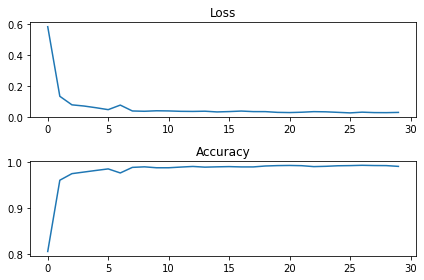

In [13]:
fig, axs = plt.subplots(2)
axs[0].plot(epoch_losses)
axs[0].set_title('Loss')
axs[1].plot(epoch_accuracies)
axs[1].set_title('Accuracy')
fig.tight_layout()

In [14]:
best_weights_model = torch.load('min_val_loss.pt')
best_weights_model.to(device)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=3136, out_features=1024, bias=True)
  (12): ReLU()
  (13): Linear(in_features=1024, out_features=512, bias=True)
  (14): ReLU()
  (15): Linear(in_features=512, out_features=10, bias=True)
)

In [15]:
accuracy.reset()

for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = best_weights_model(data)
        accuracy.update((output, target))
        
print(f'Test accuracy: {accuracy.compute()}')

Test accuracy: 0.9922
